In [1]:
# Importando arquivo de funcoes

import sys  
sys.path.insert(0, './funcoesTermosol.py')

import funcoesTermosol
import numpy as np

In [2]:
# Funcoes suporte

def getL(p1, p2):
    return np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)

def getK(E, A, p1, p2):
    
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    L = getL(p1,p2)
    
    s = (y2 - y1)/L
    c = (x2 - x1)/L
    
    K = np.array([
        [c**2, c*s, -c**2, -c*s],
        [c*s, s**2, -c*s, -s**2],
        [-c**2, -c*s, c**2, c*s],
        [-c*s, -s**2, c*s, s**2]
    ])
    
    return K*(E*A/L)

# GDP corresponde a 2x - 2 para X e 2x - 1 para Y.
# Ex. Nó 1. GDL: em X --> 0, em Y --> 1
# Ex. Nó 2. GDL: em X --> 2, em Y --> 3
# Ex. Nó 3. GDL: em X --> 4, em Y --> 5

def getGDLx(no):
    return 2*no - 2

def getGDLy(no):
    return 2*no - 1

# Matriz para passar do k do elemento para o global
def k_elemento_2_global(k_e, lista_indexes, k_global):
    
    for i in range(4):
        for j in range(4):
            k_global[lista_indexes[i]][lista_indexes[j]] += k_e[i][j]
        
    return k_global

In [3]:
def get_k_global(numero_de_nos, props_membros, nos, restricoes):

    k_global = np.zeros((numero_de_nos*2, numero_de_nos*2))
    
    # Loop principal
    for n in range(numero_de_nos):

        # Define valores do nós de análise
        no1 = int(props_membros[n][0])
        no2 = int(props_membros[n][1])

        # Gera a lista de GDP para cada elemento
        GDL_indexes = [getGDLx(no1), getGDLy(no1), getGDLx(no2), getGDLy(no2)]

        # Destrincha E e A do input
        E = props_membros[n][2]
        A = props_membros[n][3]

        # Destrincha os nós 1 e 2 de cada elemento (ajuste de index)
        p_no1 = (nos[0][no1 - 1], nos[1][no1 - 1])
        p_no2 = (nos[0][no2 - 1], nos[1][no2 - 1])

        # Gera a matriz K do elemento ja com o calculo de E*A/L
        K_elemento = getK(E, A, p_no1, p_no2)

        # Gera a matriz global
        k_global = k_elemento_2_global(K_elemento, GDL_indexes, k_global)


    # Pega a matriz global e cortar as linhas e colunas com restrição
    k_global_limpa = k_global
    for i in np.flip(restricoes):
        r = int(i[0])
        k_global_limpa = np.delete(k_global_limpa, r, 0)
        k_global_limpa = np.delete(k_global_limpa, r, 1)
        
    return k_global, k_global_limpa


In [4]:
def get_forcas_nos(forcas_nos, restricoes):
    
    # Cortando restrições da matriz global de forças
    for i in np.flip(restricoes):
        r = int(i[0])
        forcas_nos = np.delete(forcas_nos, r, 0)
        
    return forcas_nos

In [5]:
def solver_jacobi(ite, tol, n, K, F):
    
    # Criando um vetor onde será alocado as matrizes de deslocamento 
    U = np.zeros((ite+1,n))
    U[:,:] = 1.0 # Caso haja divisão por zero 
    
    for t in range(ite): # Iteração principal
        for i in range(n):
            numerator = F[i][0]
            count = n-1 # Responsável em auxiliar o uso da diagonal principal
            
            for j in range(count, -1, -1):
                 if (i != j): # Situação quando estamos na diagonal principal
                    numerator -= K[i][j]*U[t,j]
            U[t+1,i] = numerator/K[i][i] # Cálculo do deslocamento
        
        # Cálculo do erro
        anterior = U[t, 1:n-1]
        atual = U[t+1, 1:n-1]
        erro = np.amax(abs((atual - anterior)/atual))
        
        # Caso o erro seja menor que o tolerado, houve a convergência
        if (tol>=erro):
            
            #print(f'Convergência atingida na iteração: {t}')
            return U[t]
        
    # Caso ultrapasse o número de iterações, não houve convergência
    print('Não convergiu')
    return 0

In [6]:
def get_reacoes(u, restricoes, numero_de_nos, k_global):
    
    u_completo = []
    lista_restricoes = []
    for r in restricoes:
        lista_restricoes.append(int(r[0]))
    
    contador = 0
    for i in range(numero_de_nos*2):
        
        if i in lista_restricoes:
            u_completo.append(0)
            
        else:
            u_completo.append(u[contador])
            contador += 1
    
    u_completo = np.array(u_completo)
    
    reacoes = np.dot(k_global, u_completo.T)
    
    lista_de_reacoes = []
    for r in lista_restricoes:
        lista_de_reacoes.append(int(round(reacoes[r], 0)))

    return np.array(lista_de_reacoes), u_completo
    

In [7]:
def get_deformacoes(numero_de_nos, nos, deslocamentos, props_membros):
    
    nos_pos_deformacao = nos.copy()
    
    contador_x = 0
    contador_y = 0

    for d in deslocamentos:
        if contador_x == contador_y:
            nos_pos_deformacao[0][contador_x] += d
            contador_x += 1
        else:
            nos_pos_deformacao[1][contador_y] += d
            contador_y += 1

    # Loop principal
    lista_deformacoes = []
    for n in range(numero_de_nos):

        # Define valores do nós de análise
        no1 = int(props_membros[n][0])
        no2 = int(props_membros[n][1])
        
        # Destrincha os nós 1 e 2 de cada elemento (ajuste de index)
        p_no1_antigo = (nos[0][no1 - 1], nos[1][no1 - 1])
        p_no2_antigo = (nos[0][no2 - 1], nos[1][no2 - 1])
        
        # Destrincha os nós 1 e 2 de cada elemento (ajuste de index)
        p_no1_deformado = (nos_pos_deformacao[0][no1 - 1], nos_pos_deformacao[1][no1 - 1])
        p_no2_deformado = (nos_pos_deformacao[0][no2 - 1], nos_pos_deformacao[1][no2 - 1])
        
        # Encontrando tamanhos antigos e novos a partir dos nos
        l_antigo = getL(p_no1_antigo, p_no2_antigo)
        l_novo = getL(p_no1_deformado, p_no2_deformado)
        
        lista_deformacoes.append((l_novo - l_antigo)/l_antigo)
        
    return np.array(lista_deformacoes)
        

In [8]:
def get_tensoes(numero_de_nos, deformacoes, props_membros):
    
    lista_de_tensoes = []
    for i in range(numero_de_nos):
        E = props_membros[i][2]
        deform = deformacoes[i]
        lista_de_tensoes.append(E * deform)
        
    return np.array(lista_de_tensoes)

In [9]:
def get_forca_interna(numero_de_nos, props_membros, tensoes_internas):
    
    lista_de_forcas = []
    for i in range(numero_de_nos):
        A = props_membros[i][3]
        sigma = tensoes_internas[i]
        lista_de_forcas.append(A * sigma)
    
    return np.array(lista_de_forcas)

In [33]:
def main():
    
    # Importando dados
    numero_de_nos, nos, numero_de_membros, props_membros, numero_de_cargas, forcas_nos, numero_de_apoios, restricoes = funcoesTermosol.importa('./entrada2.xls')
    
    # Plot visual
    funcoesTermosol.plota(nos, props_membros)
    
    # Parametros do solver
    iteracoes = 10000
    tolerancia = 1e-8
    n = numero_de_nos*2 - len(restricoes)
    
    # Definindo matrizes de k global e forcas
    k_global, k_global_limpa = get_k_global(numero_de_nos, props_membros, nos, restricoes)
    forcas_nos = get_forcas_nos(forcas_nos, restricoes)
    print(k_global, k_global_limpa)
    
    # Aplicando solver 
    u = solver_jacobi(iteracoes, tolerancia, n, k_global_limpa, forcas_nos)
    
    # Encontrando reacoes de apoio e deslocamentos
    reacoes_de_apoio, deslocamentos = get_reacoes(u, restricoes, numero_de_nos, k_global)
    
    # Encontrando deformacoes
    deformacoes = get_deformacoes(numero_de_nos, nos, deslocamentos, props_membros)

    # Encontrando tensoes internas
    tensoes_internas = get_tensoes(numero_de_nos, deformacoes, props_membros)
    #print(tensoes_internas)
    
    # Encontrando forcas internas
    forcas_internas = get_forca_interna(numero_de_nos, props_membros, tensoes_internas)
    #print(forcas_internas)
    
    # Gerando saida
    funcoesTermosol.geraSaida("Result", reacoes_de_apoio, deslocamentos, deformacoes, forcas_internas, tensoes_internas)

    return 
    

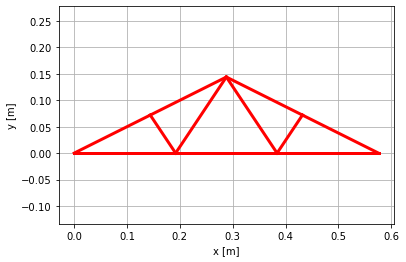

[[ 5.21749195e+05  2.60874597e+05 -5.21749195e+05 -2.60874597e+05
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.60874597e+05  1.30437299e+05 -2.60874597e+05 -1.30437299e+05
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.21749195e+05 -2.60874597e+05  1.41685429e+06 -3.82846572e+04
  -3.73355901e+05  5.60033852e+05 -5.21749195e+05 -2.60874597e+05
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.60874597e+05 -1.30437299e+05 -3.82846572e+04  1.10092538e+06
   5.60033852e+05 -8.40050778e+05 -2.60874597e+05 -1.30437299e+05
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.73355901e+05  5.60033852e+05
  

/var/folders/s4/3_q0wq016y7597pk4vtjk4rm0000gn/T/ipykernel_71455/1398377288.py:14: RuntimeWarning: overflow encountered in double_scalars
  numerator -= K[i][j]*U[t,j]
/var/folders/s4/3_q0wq016y7597pk4vtjk4rm0000gn/T/ipykernel_71455/1398377288.py:20: RuntimeWarning: invalid value encountered in true_divide
  erro = np.amax(abs((atual - anterior)/atual))
/var/folders/s4/3_q0wq016y7597pk4vtjk4rm0000gn/T/ipykernel_71455/1398377288.py:14: RuntimeWarning: invalid value encountered in double_scalars
  numerator -= K[i][j]*U[t,j]


Não convergiu


TypeError: 'int' object is not subscriptable

In [34]:
main()